### Import libraries and data

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/unique_outages.csv', parse_dates=['Start', 'Finish', 'file_name'])

# removed unplanned
df = df[df['Unplanned?'] != 1]
# filter the duration hours, only if there are expected outages, and non-outlier values, remove the one 'VIC/ TAS'
df = df[(df['Duration_Hours'] <= 1000) &(df['Duration_Hours'] != 0) & (df['Region'] != 'VIC/ TAS')]

### Create bins for the output for classification 

In [3]:
# Create quantile-based bins
quantiles = df['Duration_Hours'].quantile([0, 0.167, 0.333, 0.5, 0.667, 0.833, 1.0])
print(quantiles)

# Then manually create bins
bins = quantiles.values
labels = [f"{round(bins[i], 1)}–{round(bins[i+1], 1)} hrs" for i in range(len(bins)-1)]
df['Duration_Category'] = pd.cut(df['Duration_Hours'], bins=bins, labels=labels, include_lowest=True)
print(df['Duration_Category'].value_counts().sort_index())

0.000      0.1700
0.167      8.5000
0.333     10.0000
0.500     11.0000
0.667     12.0000
0.833     72.1368
1.000    921.6000
Name: Duration_Hours, dtype: float64
Duration_Category
0.2–8.5 hrs       394
8.5–10.0 hrs      611
10.0–11.0 hrs     179
11.0–12.0 hrs     443
12.0–72.1 hrs     314
72.1–921.6 hrs    389
Name: count, dtype: int64


### Random forest classification

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def train_and_evaluate_rf(df, train_model=True, model=None, test_size=0.2, random_state=42):

    # --- 1. Select Features and Target
    features = ['Recall_Day_Hours', 'Recall_Night_Hours', # numerical columns
                'Project Work?', 'DNSP Aware?', 'Generator Aware?', 'Inter-Regional', # boolean columns
                'Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description' # categorical coumns
                ] 
    target = 'Duration_Category'

    X = df[features].copy()
    y = df[target]

    # --- 2. Encode Categorical Features
    for col in ['Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description']:
        X[col] = LabelEncoder().fit_transform(X[col])

    # --- 3. Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # --- 4. Train Model (if needed)
    if train_model or model is None:
        model = RandomForestClassifier(random_state=random_state, class_weight='balanced')
        model.fit(X_train, y_train)

    # --- 5. Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # --- 6. Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # --- 7. Get present labels (classes that actually exist)
    full_label_order = [
        '0.2–8.5 hrs',
        '8.5–10.0 hrs',
        '10.0–11.0 hrs',
        '11.0–12.0 hrs',
        '12.0–72.1 hrs',
        '72.1–921.6 hrs'
    ]

    present_labels = [label for label in full_label_order if label in y_test.unique()]

    # --- 8. Classification Report
    print("Classification Report (Test Set):")
    print(classification_report(y_test, y_test_pred, labels=present_labels, target_names=present_labels))

    # --- 9. Visualization
   

    fig = plt.figure(figsize=(18, 16))
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

    # --- Feature Importances
    ax0 = fig.add_subplot(gs[0, :])
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = X.columns

    ax0.barh(np.array(feature_names)[indices], importances[indices], color='goldenrod')
    ax0.invert_yaxis()
    ax0.set_title("Feature Importances")
    ax0.set_xlabel("Importance")

    # --- Confusion Matrices
    cm_train = confusion_matrix(y_train, y_train_pred, labels=present_labels)
    cm_test = confusion_matrix(y_test, y_test_pred, labels=present_labels)

    ax1 = fig.add_subplot(gs[1, 0])
    disp_train = ConfusionMatrixDisplay(cm_train, display_labels=present_labels)
    disp_train.plot(ax=ax1, cmap='viridis', xticks_rotation=45, values_format='d', colorbar=False)
    ax1.set_title(f"Train Confusion Matrix\n(Acc: {train_acc:.2%})")

    ax2 = fig.add_subplot(gs[1, 1])
    disp_test = ConfusionMatrixDisplay(cm_test, display_labels=present_labels)
    disp_test.plot(ax=ax2, cmap='viridis', xticks_rotation=45, values_format='d', colorbar=False)
    ax2.set_title(f"Test Confusion Matrix\n(Acc: {test_acc:.2%})")

    # --- Duration Category Distributions
    # Dynamically detect available categories in training/testing sets
    train_categories = y_train.value_counts().sort_index()
    test_categories = y_test.value_counts().sort_index()

    # Sort by full_label_order if available
    train_counts = train_categories.reindex([label for label in full_label_order if label in train_categories.index])
    test_counts = test_categories.reindex([label for label in full_label_order if label in test_categories.index])

    ax3 = fig.add_subplot(gs[2, 0])
    ax3.bar(train_counts.index, train_counts.values, color='darkcyan')
    ax3.set_title("Train Set Duration Category Distribution")
    ax3.set_xlabel("Duration Category")
    ax3.set_ylabel("Count")
    ax3.tick_params(axis='x', rotation=45)

    ax4 = fig.add_subplot(gs[2, 1])
    ax4.bar(test_counts.index, test_counts.values, color='slateblue')
    ax4.set_title("Test Set Duration Category Distribution")
    ax4.set_xlabel("Duration Category")
    ax4.set_ylabel("Count")
    ax4.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()
    
    return model  # Return model for possible reuse

Classification Report (Test Set):
                precision    recall  f1-score   support

   0.2–8.5 hrs       0.70      0.76      0.73        67
  8.5–10.0 hrs       0.72      0.50      0.59       128
 10.0–11.0 hrs       0.30      0.85      0.44        33
 11.0–12.0 hrs       0.79      0.65      0.71        82
 12.0–72.1 hrs       0.59      0.48      0.53        81
72.1–921.6 hrs       0.77      0.79      0.78        75

      accuracy                           0.63       466
     macro avg       0.64      0.67      0.63       466
  weighted avg       0.68      0.63      0.64       466



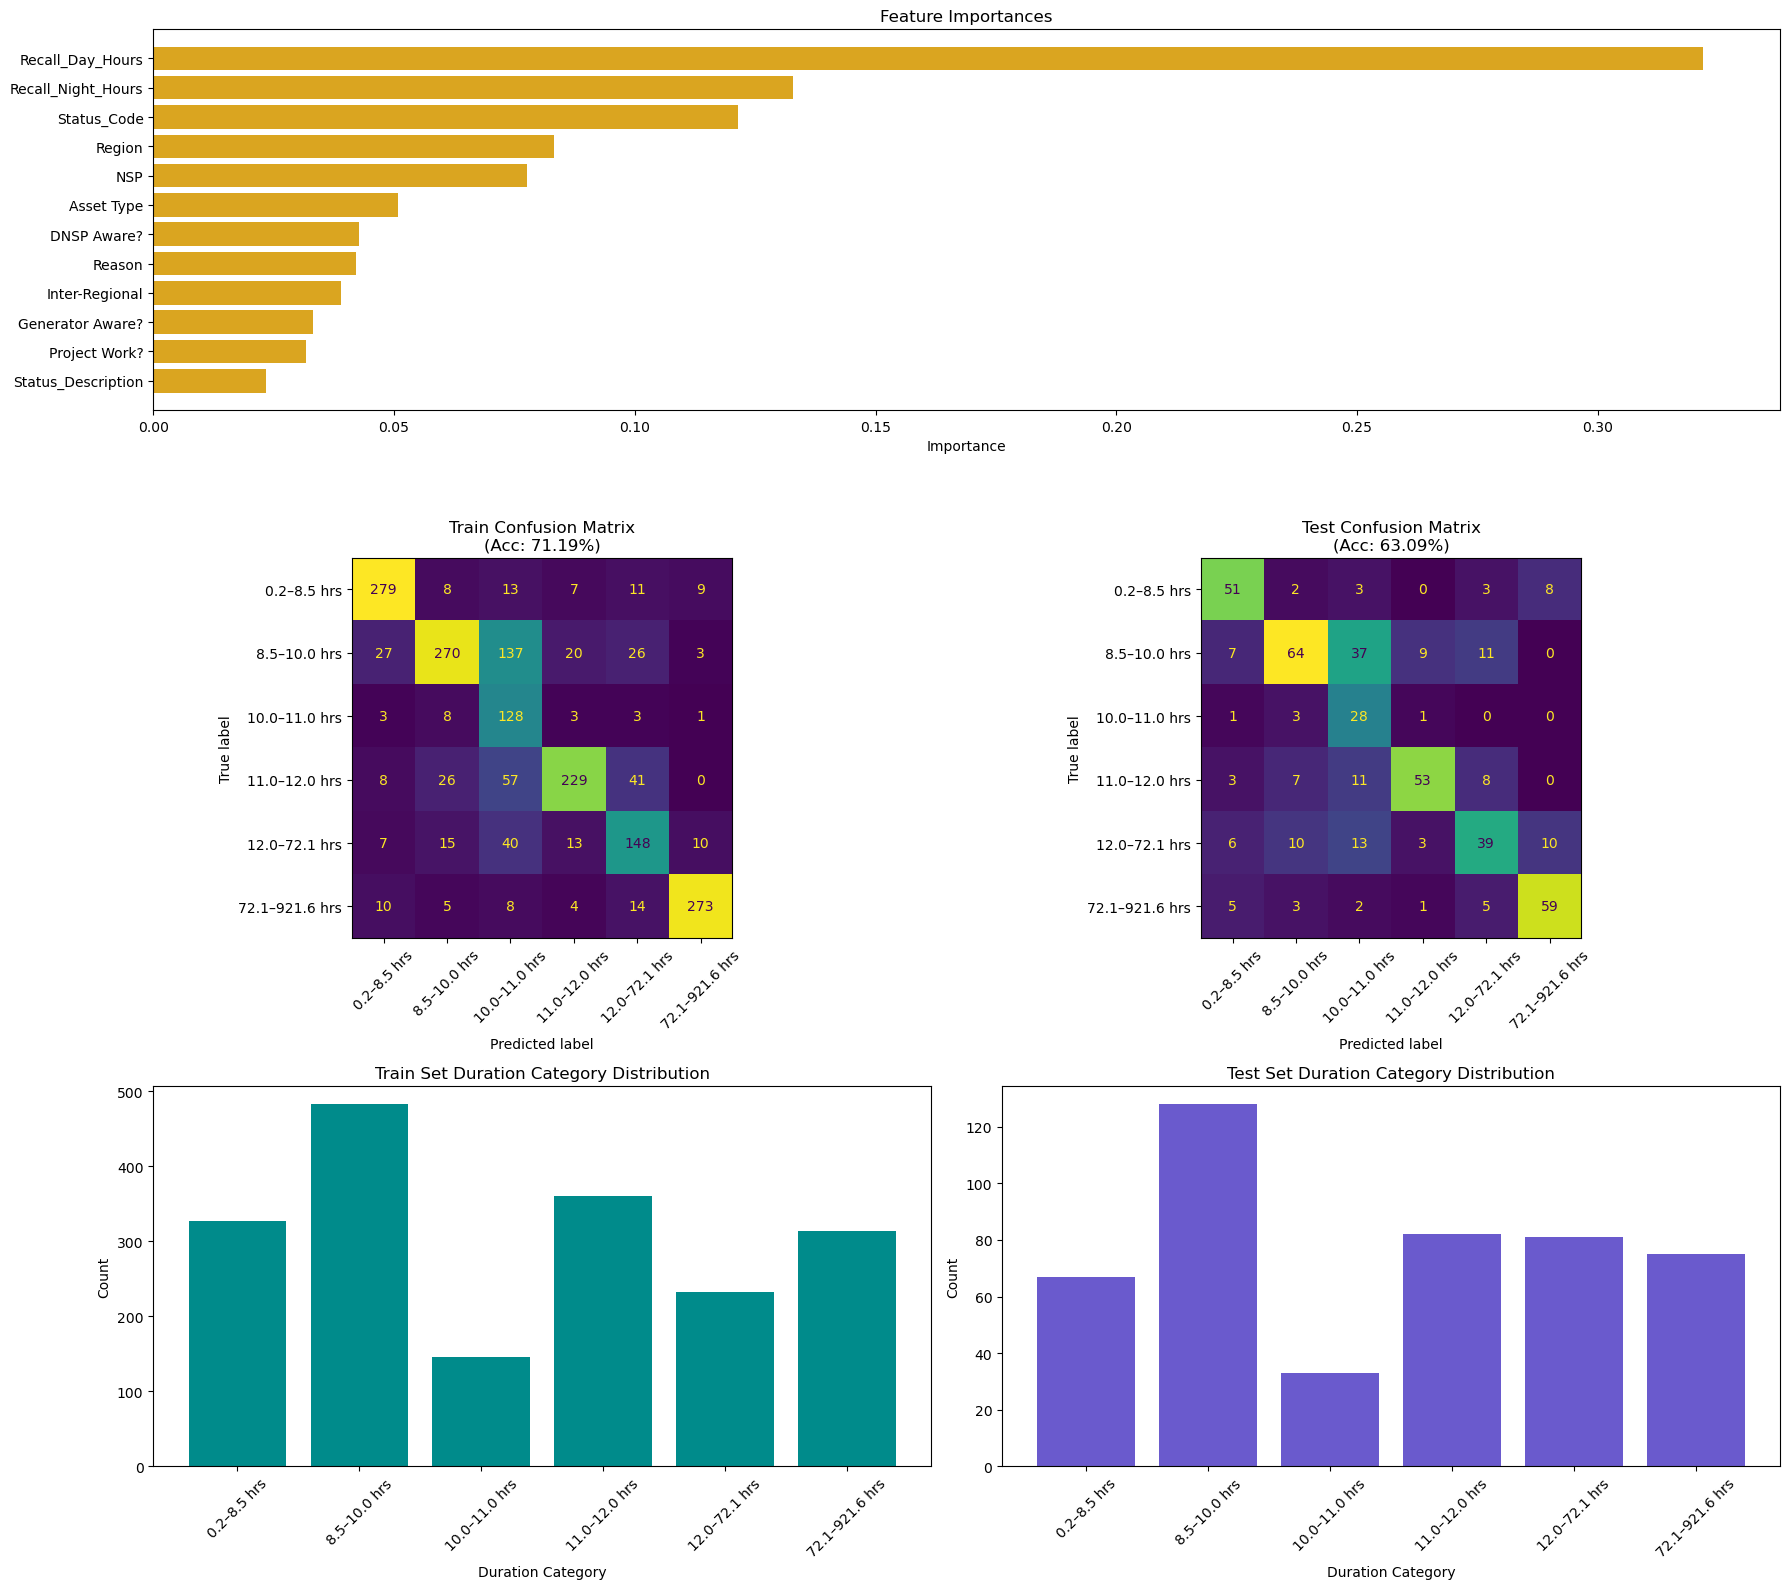

In [8]:
# from data.functions.random_forest_model_and_eval import train_and_evaluate_rf
model = train_and_evaluate_rf(df)

--- Region: SA ---
Classification Report (Test Set):
                precision    recall  f1-score   support

   0.2–8.5 hrs       0.67      0.43      0.52        14
  8.5–10.0 hrs       0.00      0.00      0.00         1
 10.0–11.0 hrs       0.00      0.00      0.00         1
 11.0–12.0 hrs       0.43      0.75      0.55         4
 12.0–72.1 hrs       0.45      0.83      0.59        12
72.1–921.6 hrs       1.00      0.77      0.87        26

      accuracy                           0.67        58
     macro avg       0.42      0.46      0.42        58
  weighted avg       0.73      0.67      0.68        58



c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


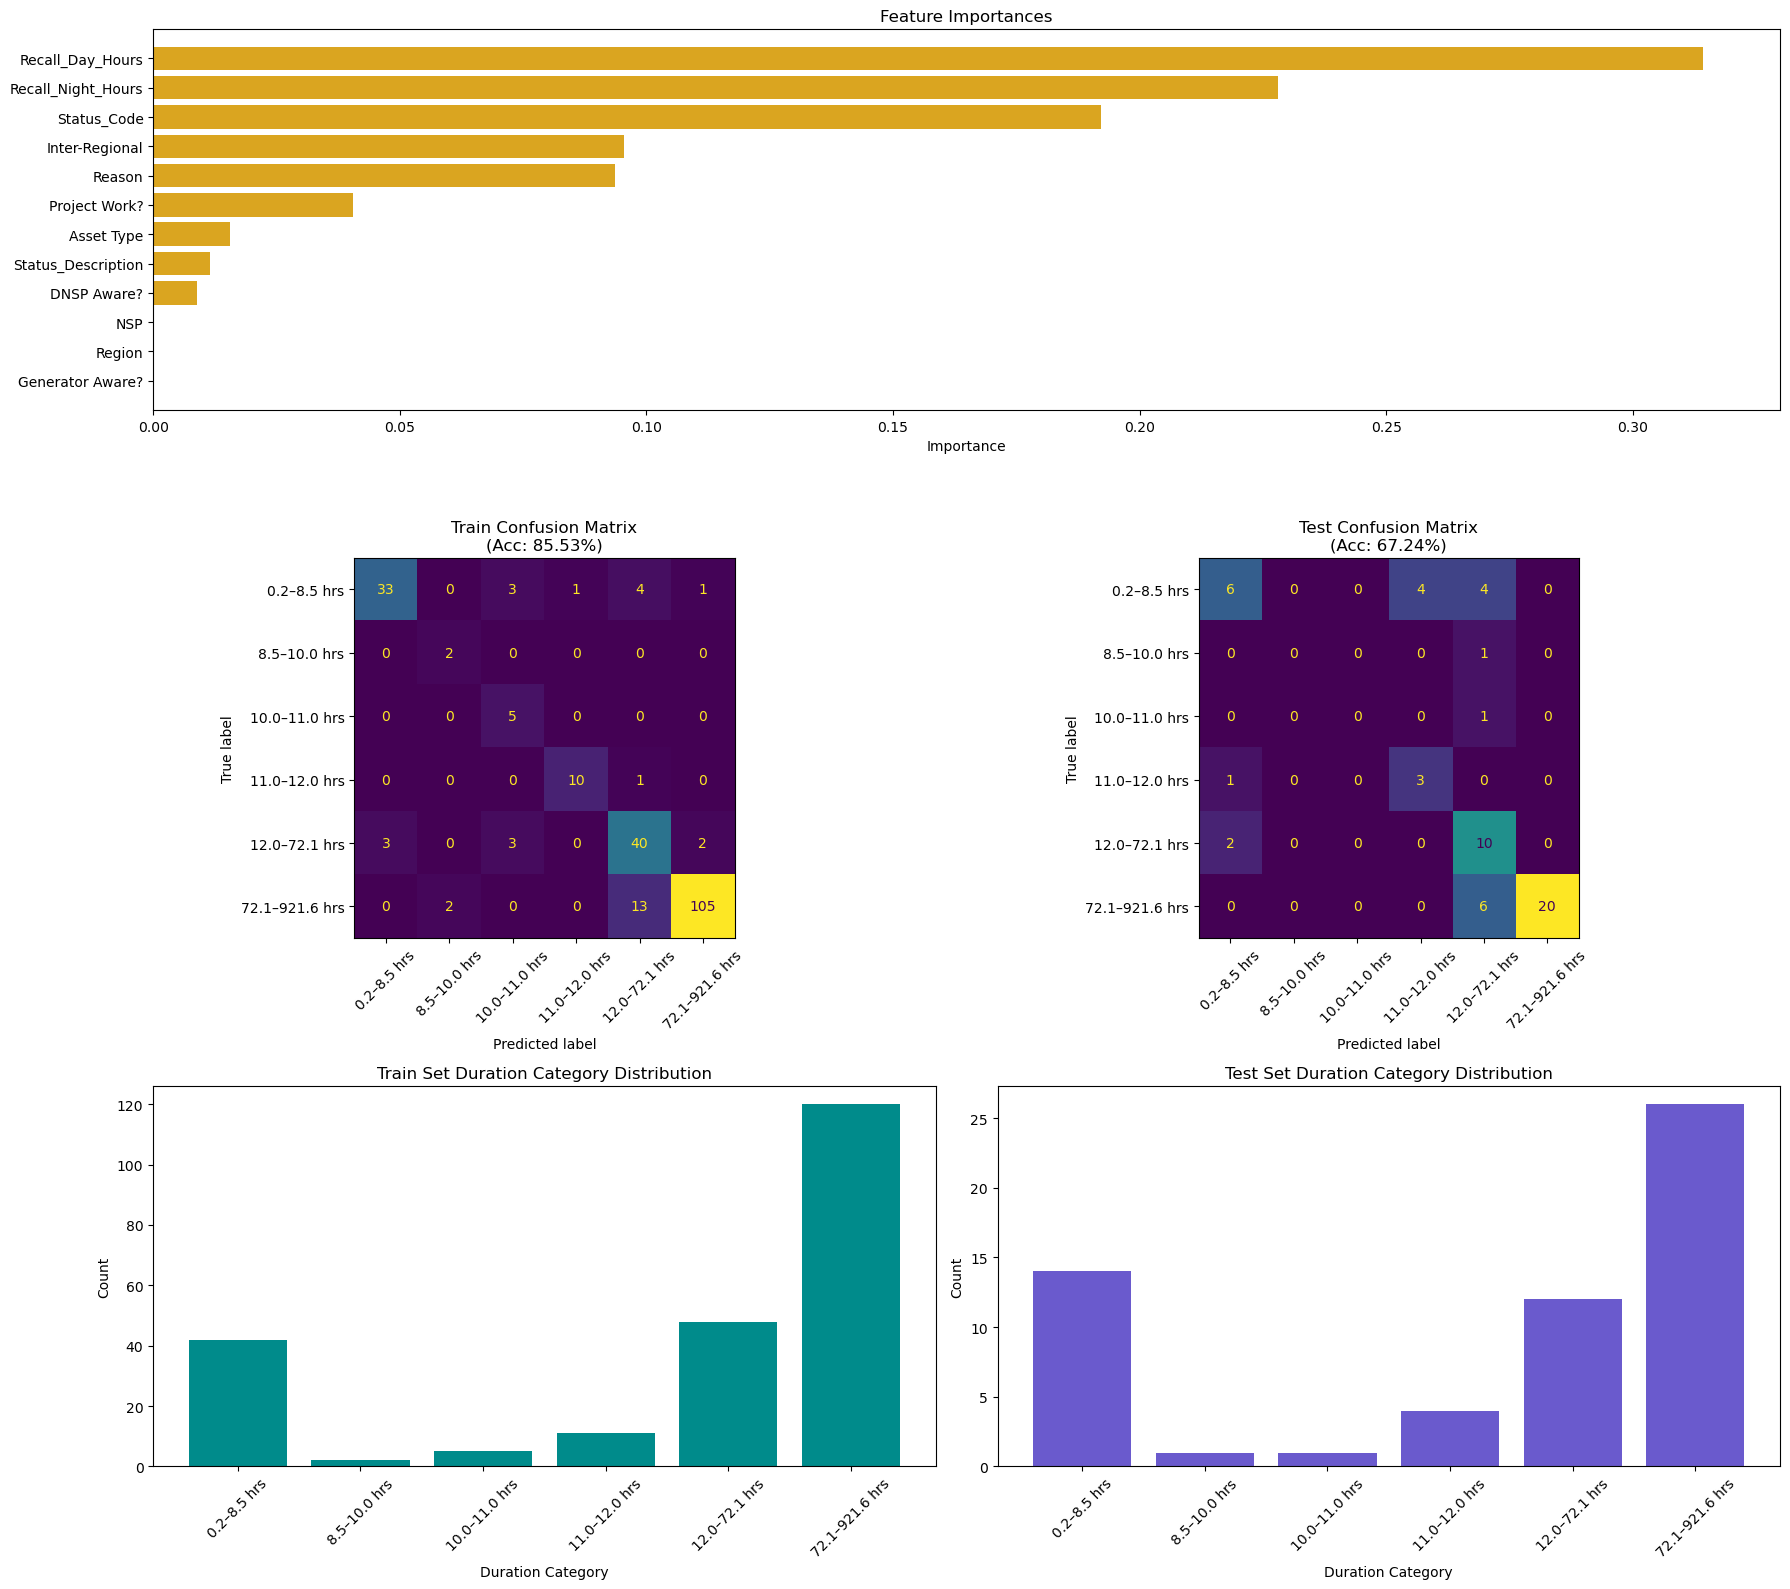

--- Region: VIC ---
Classification Report (Test Set):
                precision    recall  f1-score   support

   0.2–8.5 hrs       0.39      0.53      0.45        17
  8.5–10.0 hrs       0.70      0.35      0.46        81
 10.0–11.0 hrs       0.26      0.79      0.40        24
 11.0–12.0 hrs       0.82      0.62      0.71        90
 12.0–72.1 hrs       0.29      0.38      0.33        29
72.1–921.6 hrs       0.50      0.50      0.50        10

      accuracy                           0.51       251
     macro avg       0.49      0.53      0.47       251
  weighted avg       0.63      0.51      0.53       251



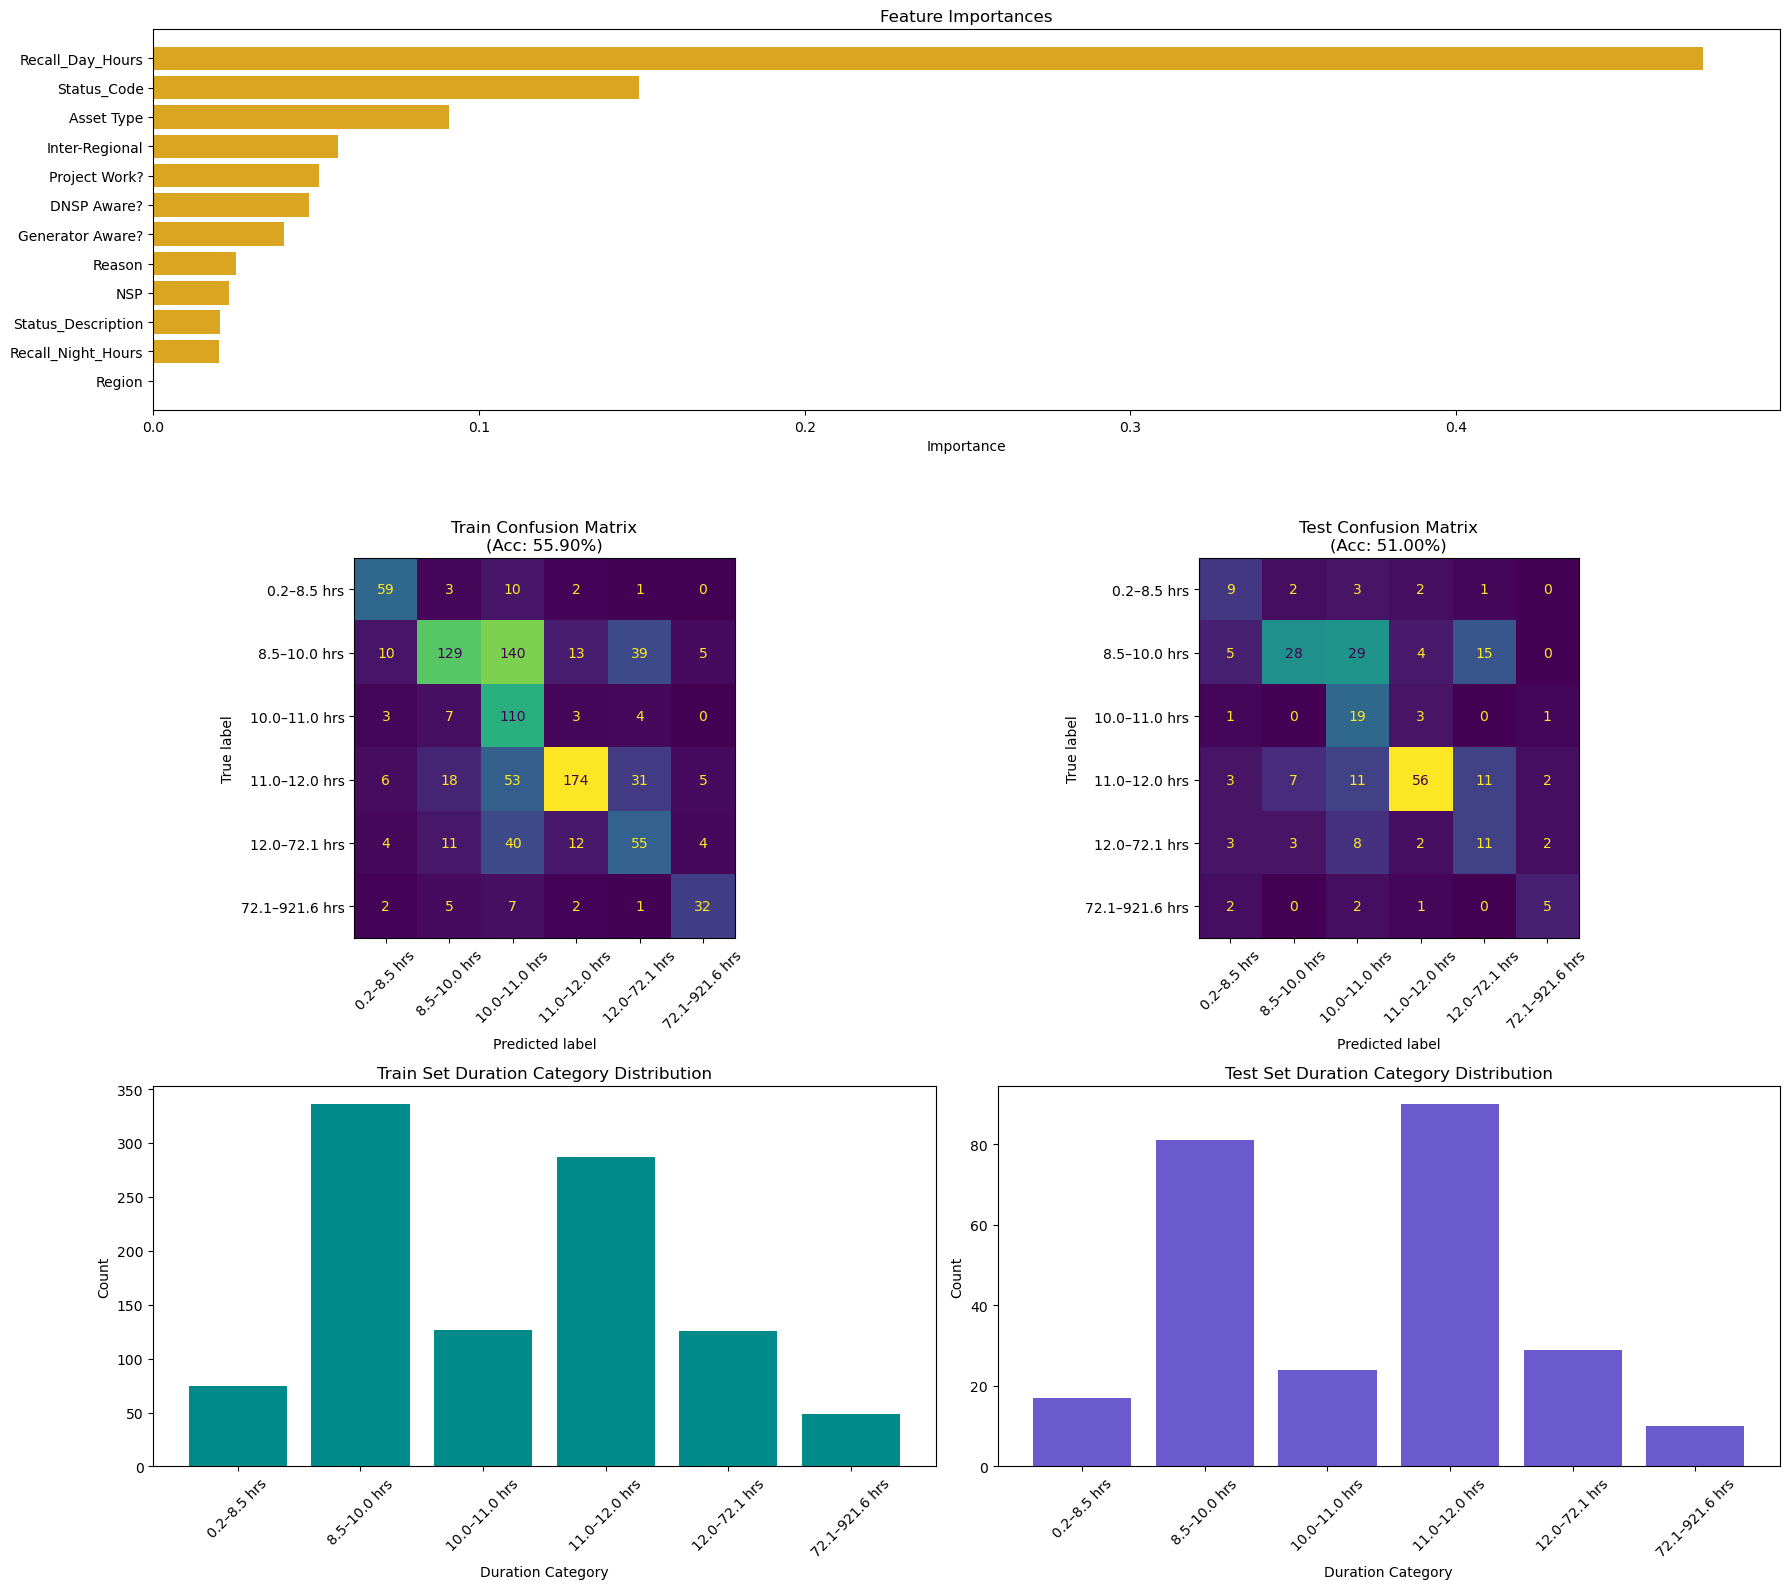

--- Region: TAS ---
Classification Report (Test Set):
                precision    recall  f1-score   support

   0.2–8.5 hrs       0.79      0.65      0.71        17
  8.5–10.0 hrs       0.00      0.00      0.00         1
 12.0–72.1 hrs       0.20      1.00      0.33         1
72.1–921.6 hrs       1.00      0.60      0.75        10

     micro avg       0.64      0.62      0.63        29
     macro avg       0.50      0.56      0.45        29
  weighted avg       0.81      0.62      0.69        29



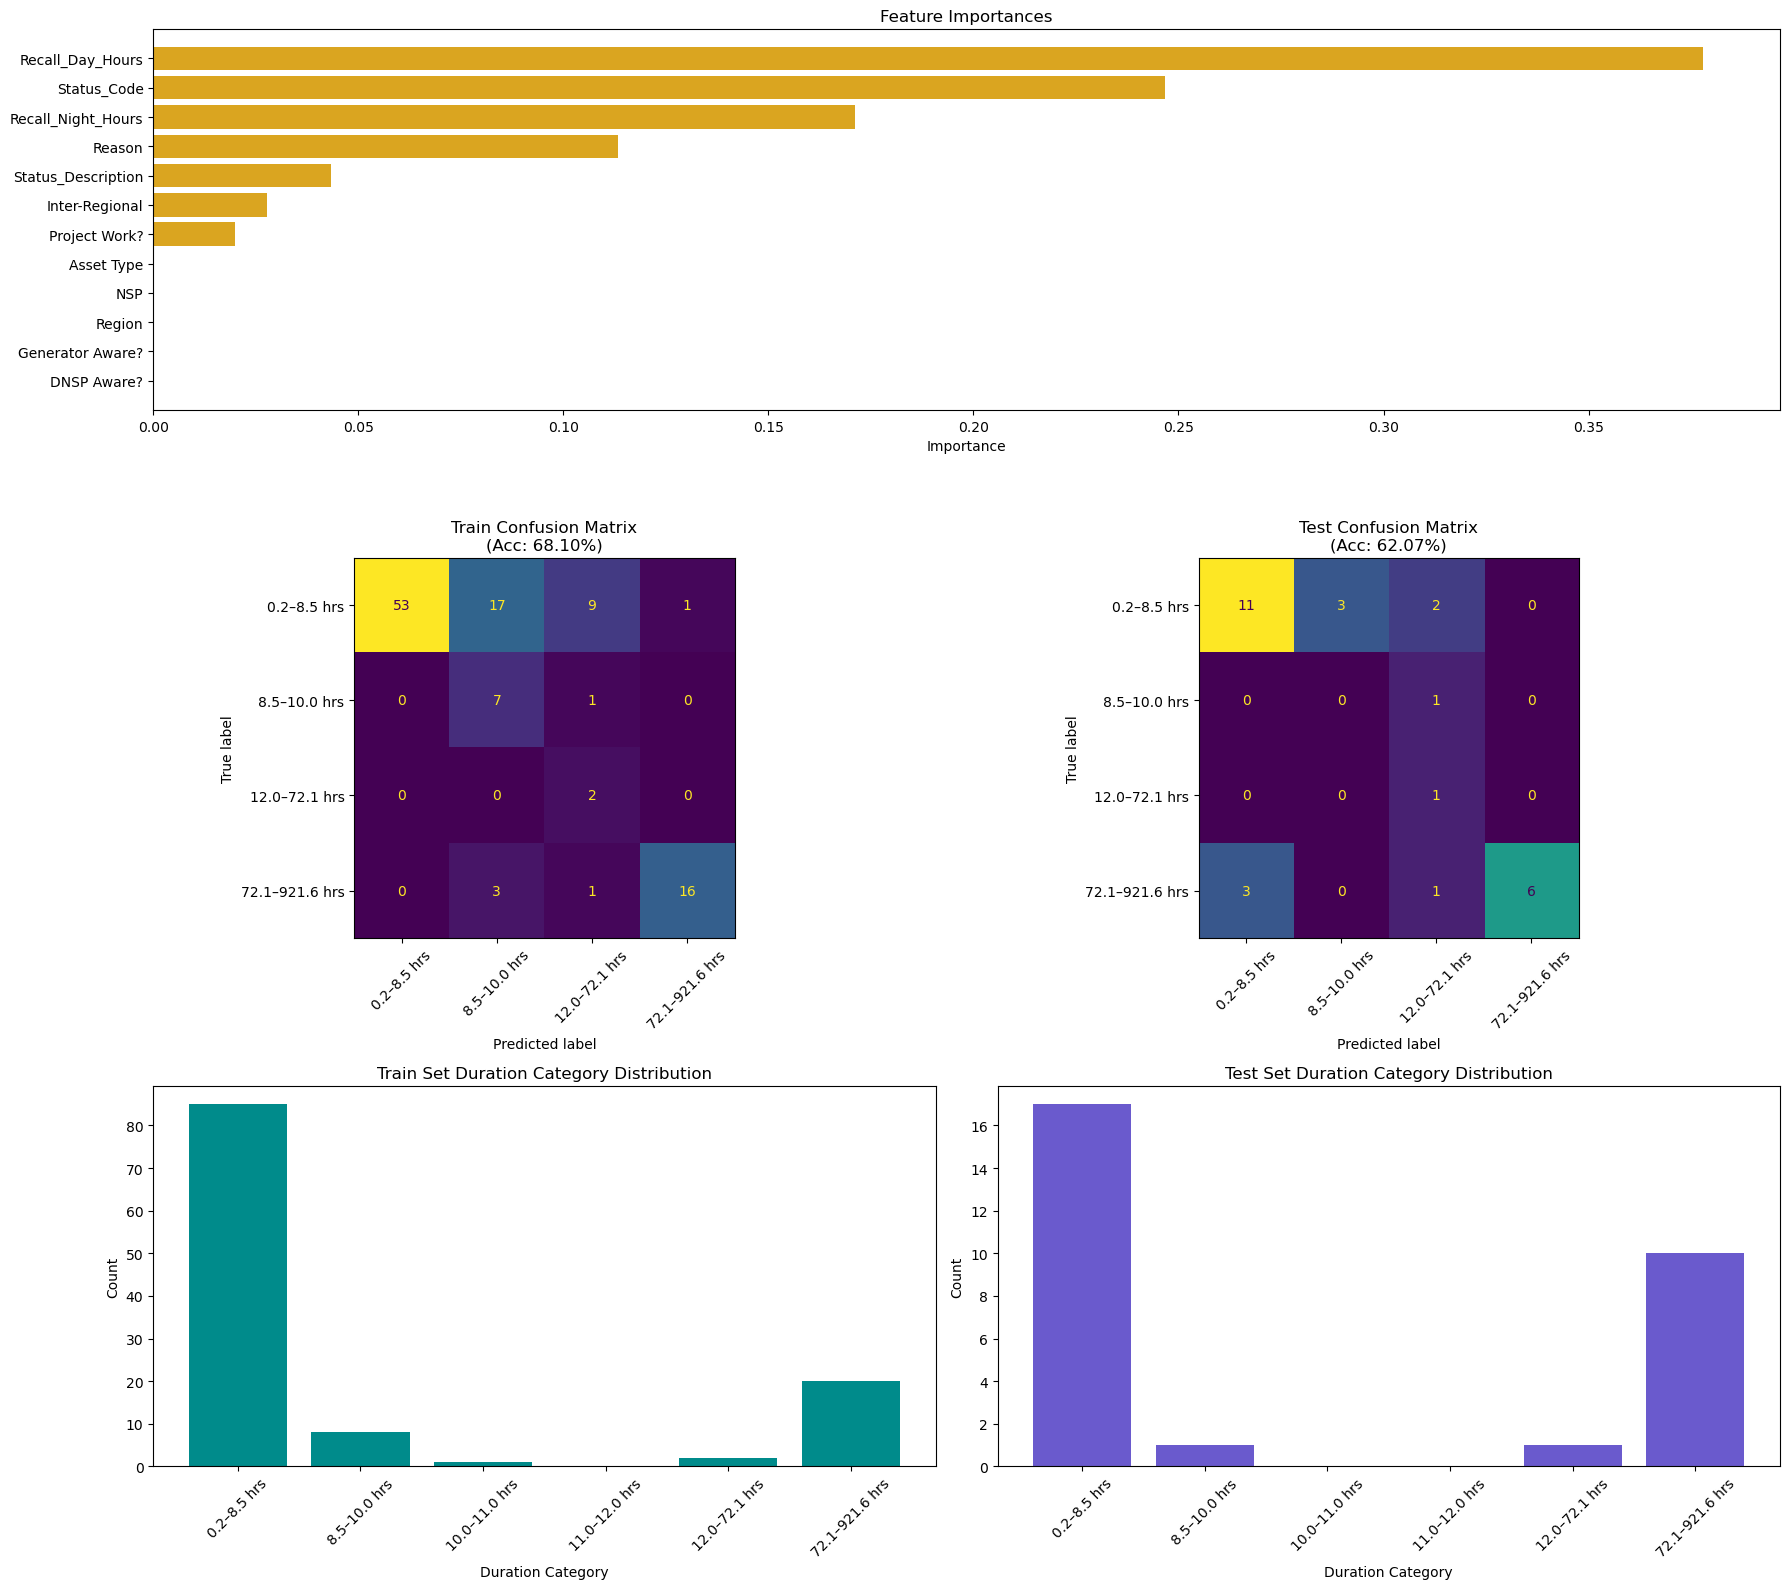

--- Region: QLD ---
Classification Report (Test Set):
                precision    recall  f1-score   support

   0.2–8.5 hrs       0.64      0.89      0.74        18
  8.5–10.0 hrs       0.94      0.60      0.73        25
 10.0–11.0 hrs       0.00      0.00      0.00         1
 12.0–72.1 hrs       0.38      0.62      0.48         8
72.1–921.6 hrs       0.85      0.71      0.77        24

     micro avg       0.72      0.70      0.71        76
     macro avg       0.56      0.56      0.54        76
  weighted avg       0.77      0.70      0.71        76



c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jerry Z\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


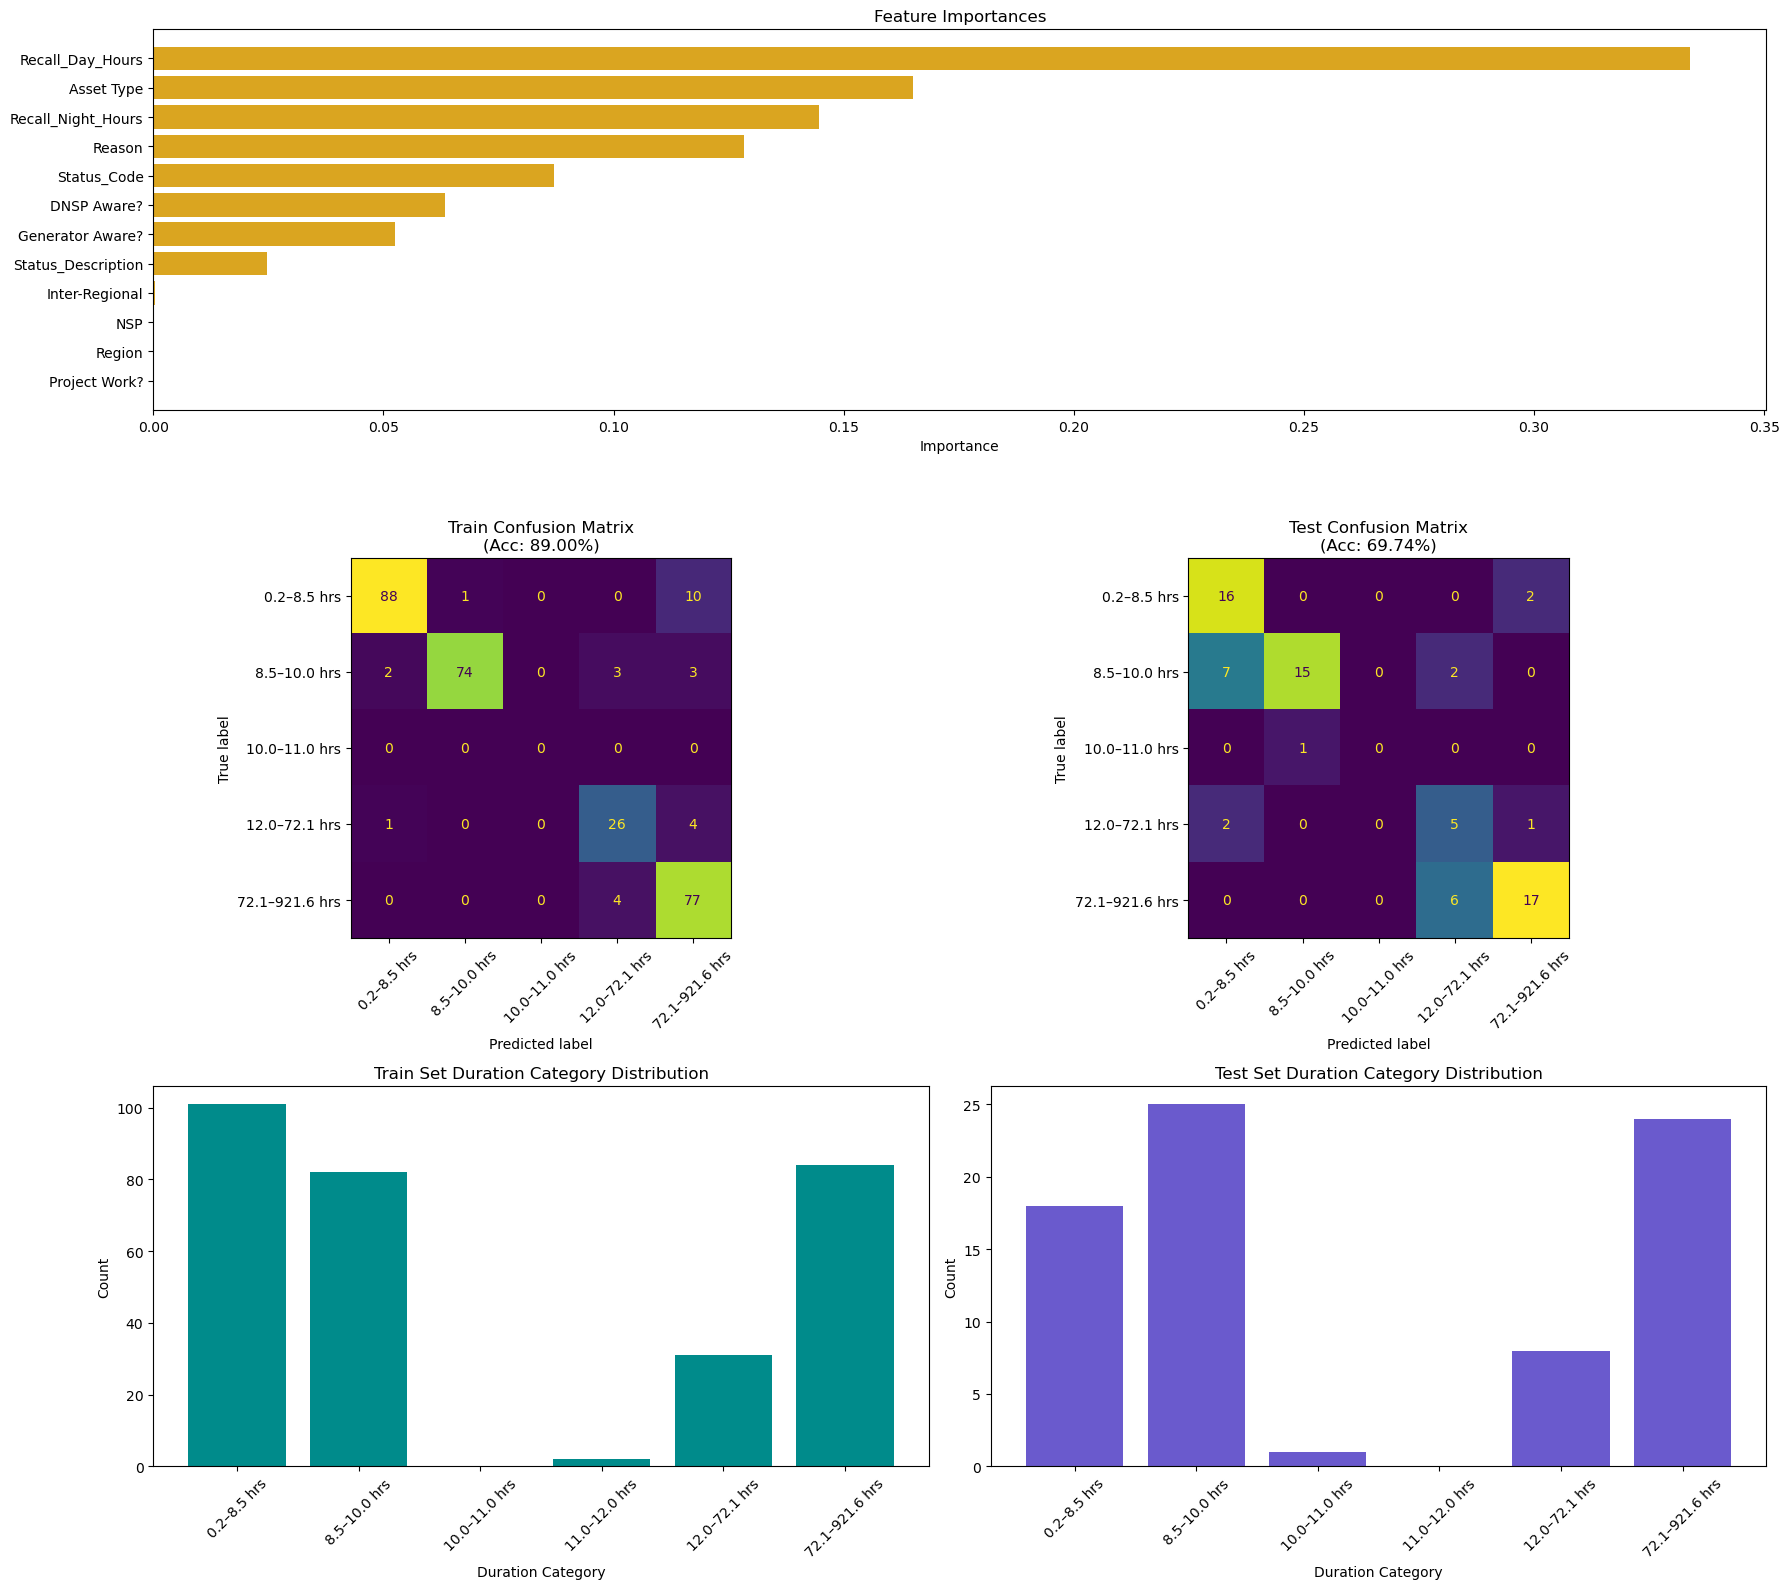

--- Region: NSW ---
Classification Report (Test Set):
                precision    recall  f1-score   support

   0.2–8.5 hrs       0.33      0.60      0.43         5
  8.5–10.0 hrs       0.83      0.83      0.83        12
 10.0–11.0 hrs       1.00      0.33      0.50         3
 11.0–12.0 hrs       0.88      0.70      0.78        10
 12.0–72.1 hrs       0.53      0.67      0.59        12
72.1–921.6 hrs       0.90      0.69      0.78        13

      accuracy                           0.69        55
     macro avg       0.75      0.64      0.65        55
  weighted avg       0.75      0.69      0.70        55



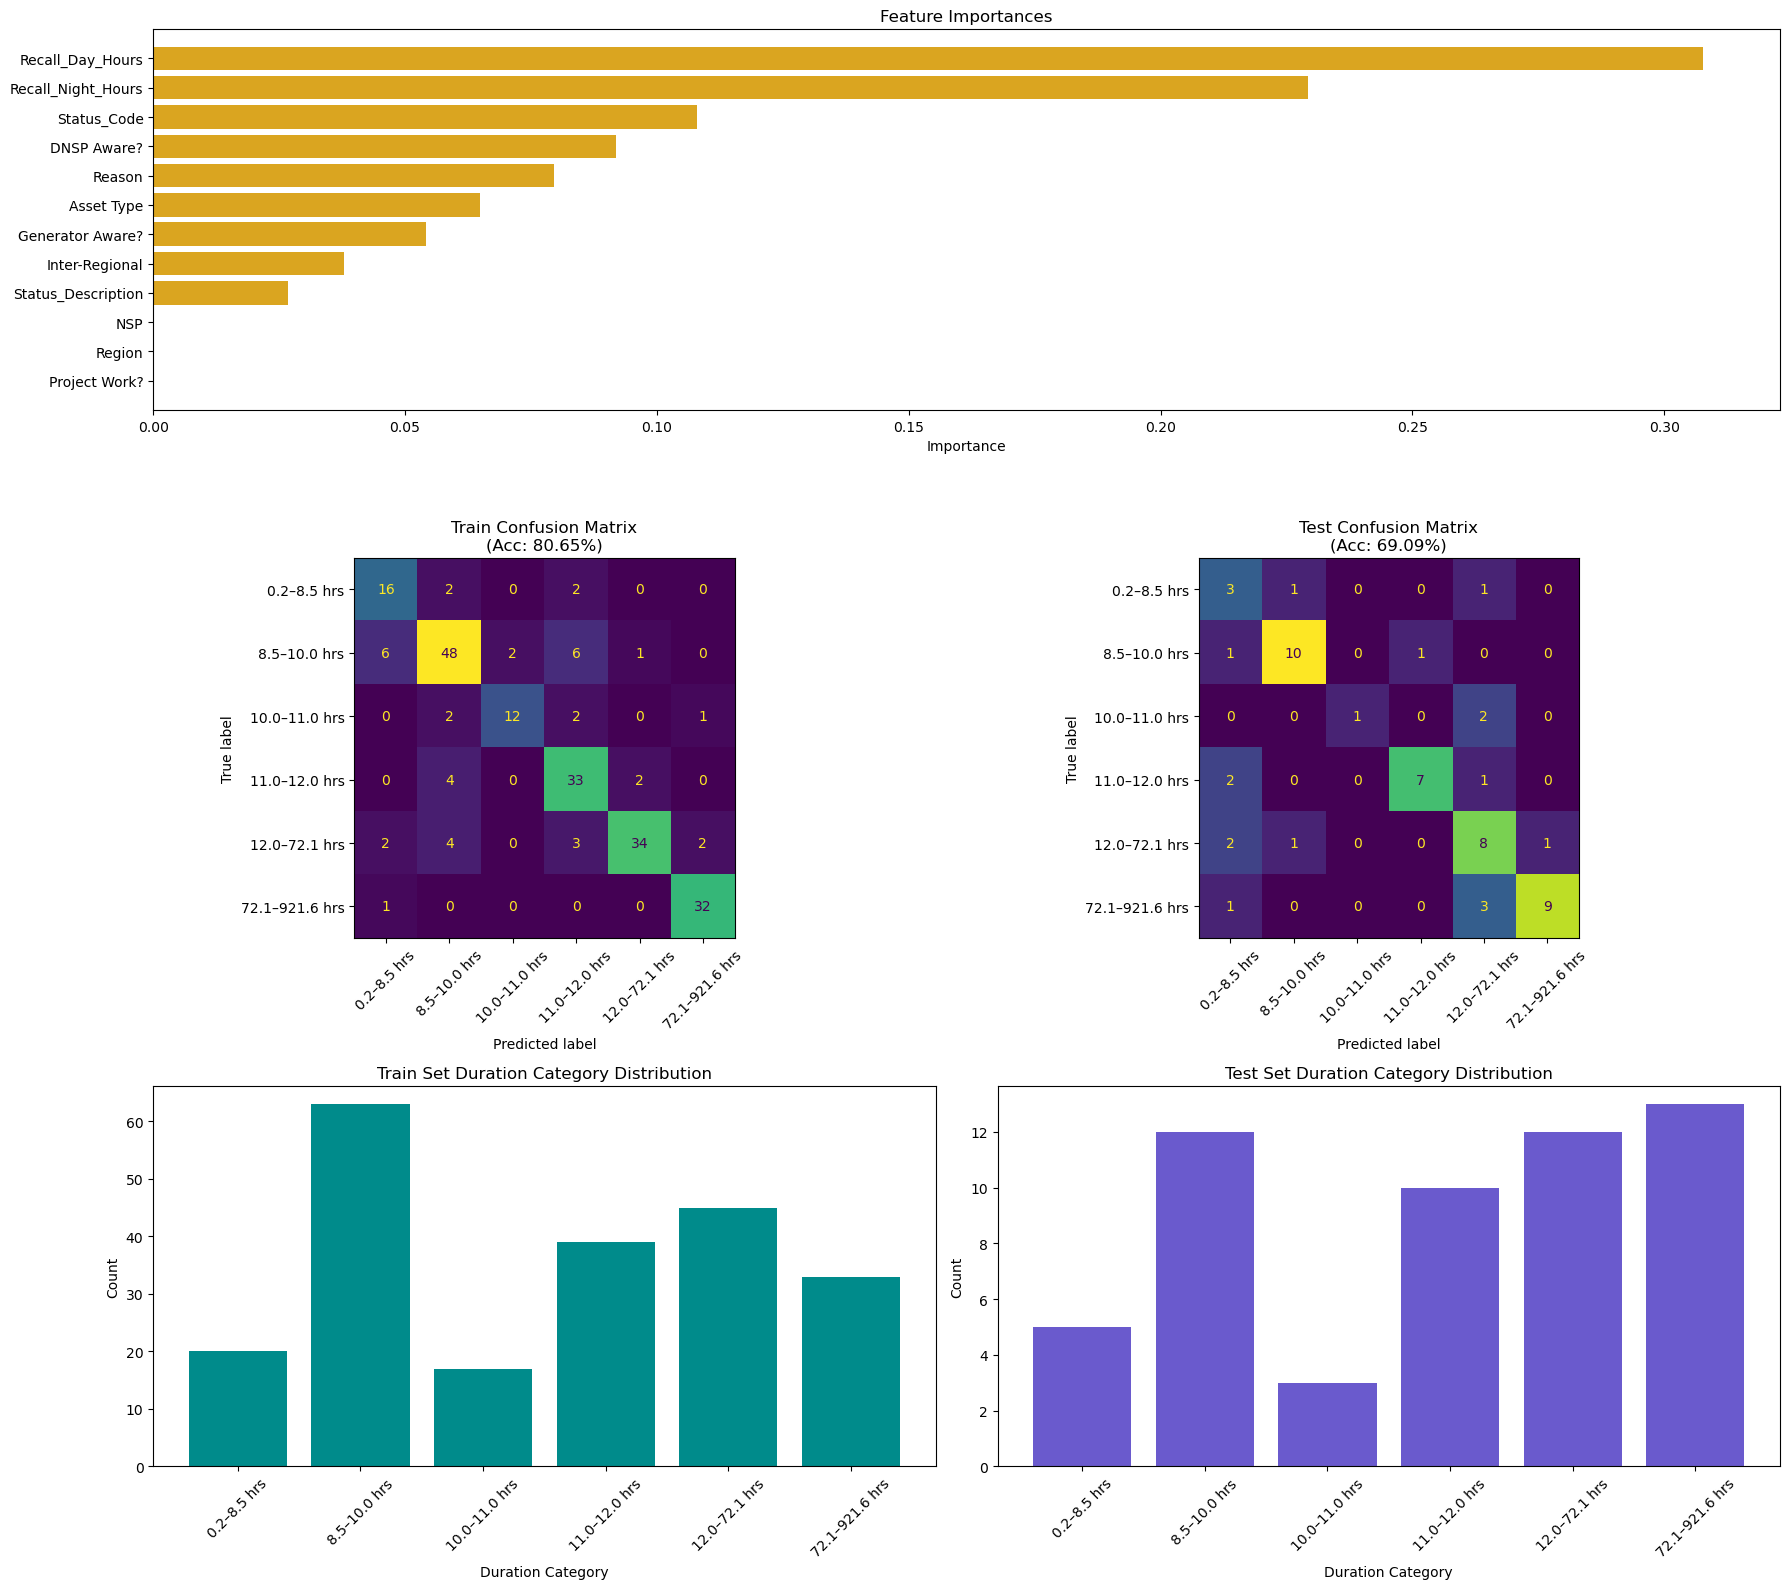

In [9]:
region_models = {}
for region in df['Region'].unique():
    region_df = df[df['Region'] == region].copy()
    print(f"--- Region: {region} ---")
    model = train_and_evaluate_rf(region_df)
    region_models[region] = model